# GAN Demo

## 0. setup

#### 0.1. imports

In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.utils import resample
from matplotlib import pyplot as plt

from full_gan import Gan

#### 0.2. configuration

In [2]:
EPOCHS = 100
BATCHES = [ {"real": 128, "fake": 128, "l_v": 256} for x in range(23) ]

SNAPSHOT_CYCLE = 10
SNAPSHOT_SIZE = 100

SAMPLE_SIZE = 100

MODEL_PATH = "./output/3GAN_100_model.h5"

## 1. prepare data

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X = X_train
X = np.take(X, [ x for x, elem in enumerate(y_train) if elem == 3 ] , axis=0)
X = np.expand_dims(X, -1)
X = X / 255

y = np.take(y_train, [ x for x, elem in enumerate(y_train) if elem == 3 ] , axis=0)

## 2. setup GAN model

#### 2.1. discriminator model

In [4]:
discriminator = keras.Sequential()
discriminator.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.4))
discriminator.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(keras.layers.LeakyReLU(alpha=0.2))
discriminator.add(keras.layers.Dropout(0.4))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

#### 2.2. generator model

In [5]:
generator = keras.Sequential()
generator.add(keras.layers.Dense(128 * 7 * 7, input_dim=100))
generator.add(keras.layers.LeakyReLU(alpha=0.2))
generator.add(keras.layers.Reshape((7,7,128)))
generator.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))
generator.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
generator.add(keras.layers.LeakyReLU(alpha=0.2))
generator.add(keras.layers.Conv2D(1, (7,7), activation="sigmoid", padding="same"))

#### 2.3. GAN model 

In [6]:
gan = Gan(discriminator, generator, "binary_crossentropy", keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

In [7]:
Gan.l_v = lambda shape : np.random.normal(0, 1, shape)

## 3. train the model

#### 3.1. feeding the model with data

In [8]:
for i in range(EPOCHS):
	for batch in BATCHES:

		#discriminator
		X_real, y_real = resample(X, n_samples=batch["real"]), np.ones((batch["real"], 1))
		X_fake, y_fake = gan(n=batch["fake"]), np.zeros((batch["fake"], 1))
		X_disc, y_disc = np.concatenate((X_real, X_fake)), np.concatenate((y_real, y_fake))

		#gan /generator
		X_gan = Gan.l_v( (256, 100, 1) )

		#train
		d_loss, g_loss = gan.update(X_disc, y_disc, X_gan)


	if (i + 1) % SNAPSHOT_CYCLE == 0:
		MODEL_PATH, _ = gan.snapshot("./output/3GAN_" + str(i + 1), SNAPSHOT_SIZE)
		print("saved -", end="")

	print("> " + str("%d%s" % (i+1,"tsnrhtdd"[((i+1)//10%10!=1)*((i+1)%10<4)*(i+1)%10::4])), "epoch:", "d_loss=" + str(d_loss) + ",", "g_loss=" + str(g_loss))

> 1st epoch: d_loss=0.5872829556465149, g_loss=0.7062200307846069
> 2nd epoch: d_loss=0.3822111189365387, g_loss=0.7493472099304199
> 3rd epoch: d_loss=0.22013252973556519, g_loss=1.1355290412902832
> 4th epoch: d_loss=0.06761234998703003, g_loss=2.326098680496216
> 5th epoch: d_loss=0.27890896797180176, g_loss=2.0592944622039795
> 6th epoch: d_loss=0.451587975025177, g_loss=1.4383149147033691
> 7th epoch: d_loss=0.5836511850357056, g_loss=1.0625381469726562
> 8th epoch: d_loss=0.9728869199752808, g_loss=0.5040212273597717
> 9th epoch: d_loss=0.7883949875831604, g_loss=0.7659796476364136
saved -> 10th epoch: d_loss=0.7854762673377991, g_loss=0.705397367477417
> 11th epoch: d_loss=0.7208887338638306, g_loss=0.701327919960022
> 12th epoch: d_loss=0.7892707586288452, g_loss=0.6079362034797668
> 13th epoch: d_loss=0.7779138088226318, g_loss=0.7115966081619263
> 14th epoch: d_loss=0.6796082258224487, g_loss=0.7412810325622559
> 15th epoch: d_loss=0.6915302276611328, g_loss=0.78846275806427


## 4. model demo

#### 4.1. load newest model

In [9]:
l_model = keras.models.load_model(MODEL_PATH)
l_discriminator = l_model.layers[1]
l_generator = l_model.layers[0]

l_gan = Gan(l_discriminator, l_generator, "binary_crossentropy", keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

#### 4.2. sample from the model

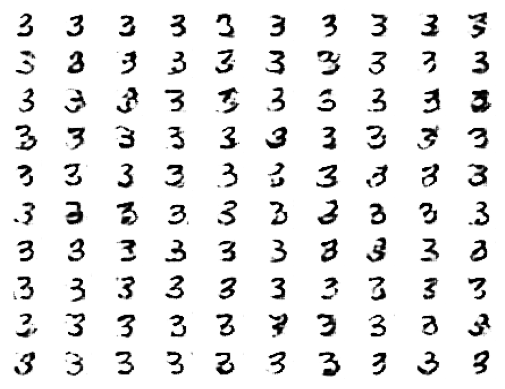

In [10]:
samples = l_gan(n=SAMPLE_SIZE)

for i, sample in enumerate(samples):
    plt.subplot(int(np.sqrt(SAMPLE_SIZE)), int(np.sqrt(SAMPLE_SIZE)), 1 + i)
    plt.axis('off')
    plt.imshow(sample, cmap='gray_r')